In [2]:
from openvino.runtime import serialize
from openvino.tools import mo

model = mo.convert_model('cfg/deploy/yolov7.onnx')
serialize(model, xml_path="cfg/deploy/yolov7.xml", bin_path="cfg/deploy/yolov7.bin")

In [3]:
import numpy as np
import torch
from PIL import Image
from utils.datasets import letterbox
from utils.plots import plot_one_box


def preprocess_image(img0: np.ndarray):
    """
    Preprocess image according to YOLOv7 input requirements.
    Takes image in np.array format, resizes it to specific size using letterbox resize, converts color space from BGR (default in OpenCV) to RGB and changes data layout from HWC to CHW.

    Parameters:
      img0 (np.ndarray): image for preprocessing
    Returns:
      img (np.ndarray): image after preprocessing
      img0 (np.ndarray): original image
    """
    # resize
    img = letterbox(img0, auto=False)[0]

    # Convert
    img = img.transpose(2, 0, 1)
    img = np.ascontiguousarray(img)
    return img, img0


def prepare_input_tensor(image: np.ndarray):
    """
    Converts preprocessed image to tensor format according to YOLOv7 input requirements.
    Takes image in np.array format with unit8 data in [0, 255] range and converts it to torch.Tensor object with float data in [0, 1] range

    Parameters:
      image (np.ndarray): image for conversion to tensor
    Returns:
      input_tensor (torch.Tensor): float tensor ready to use for YOLOv7 inference
    """
    input_tensor = image.astype(np.float32)  # uint8 to fp16/32
    input_tensor /= 255.0  # 0 - 255 to 0.0 - 1.0

    if input_tensor.ndim == 3:
        input_tensor = np.expand_dims(input_tensor, 0)
    return input_tensor


# label names for visualization
NAMES = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

# colors for visualization
COLORS = {name: [np.random.randint(0, 255) for _ in range(3)]
          for i, name in enumerate(NAMES)}

In [6]:
from typing import List, Tuple, Dict
from utils.general import scale_coords, non_max_suppression
from openvino.runtime import Model


def detect(model: Model, image_path, conf_thres: float = 0.25, iou_thres: float = 0.45, classes: List[int] = None, agnostic_nms: bool = False):
    """
    OpenVINO YOLOv7 model inference function. Reads image, preprocess it, runs model inference and postprocess results using NMS.
    Parameters:
        model (Model): OpenVINO compiled model.
        image_path (Path): input image path.
        conf_thres (float, *optional*, 0.25): minimal accpeted confidence for object filtering
        iou_thres (float, *optional*, 0.45): minimal overlap score for remloving objects duplicates in NMS
        classes (List[int], *optional*, None): labels for prediction filtering, if not provided all predicted labels will be used
        agnostic_nms (bool, *optiona*, False): apply class agnostinc NMS approach or not
    Returns:
       pred (List): list of detections with (n,6) shape, where n - number of detected boxes in format [x1, y1, x2, y2, score, label]
       orig_img (np.ndarray): image before preprocessing, can be used for results visualization
       inpjut_shape (Tuple[int]): shape of model input tensor, can be used for output rescaling
    """
    output_blob = model.output(0)
    img = np.array(Image.open(image_path))
    preprocessed_img, orig_img = preprocess_image(img)
    input_tensor = prepare_input_tensor(preprocessed_img)
    predictions = torch.from_numpy(model(input_tensor)[output_blob])
    pred = non_max_suppression(predictions, conf_thres, iou_thres, classes=classes, agnostic=agnostic_nms)
    return pred, orig_img, input_tensor.shape


def draw_boxes(predictions: np.ndarray, input_shape: Tuple[int], image: np.ndarray, names: List[str], colors: Dict[str, int]):
    """
    Utility function for drawing predicted bounding boxes on image
    Parameters:
        predictions (np.ndarray): list of detections with (n,6) shape, where n - number of detected boxes in format [x1, y1, x2, y2, score, label]
        image (np.ndarray): image for boxes visualization
        names (List[str]): list of names for each class in dataset
        colors (Dict[str, int]): mapping between class name and drawing color
    Returns:
        image (np.ndarray): box visualization result
    """
    if not len(predictions):
        return image
    # Rescale boxes from input size to original image size
    predictions[:, :4] = scale_coords(input_shape[2:], predictions[:, :4], image.shape).round()

    # Write results
    for *xyxy, conf, cls in reversed(predictions):
        label = f'{names[int(cls)]} {conf:.2f}'
        plot_one_box(xyxy, image, label=label, color=colors[names[int(cls)]], line_thickness=1)
    return image

In [4]:
from openvino.runtime import Core
core = Core()
# read converted model
model = core.read_model('cfg/deploy/yolov7.xml')
# load model on CPU device
compiled_model = core.compile_model(model, 'CPU')

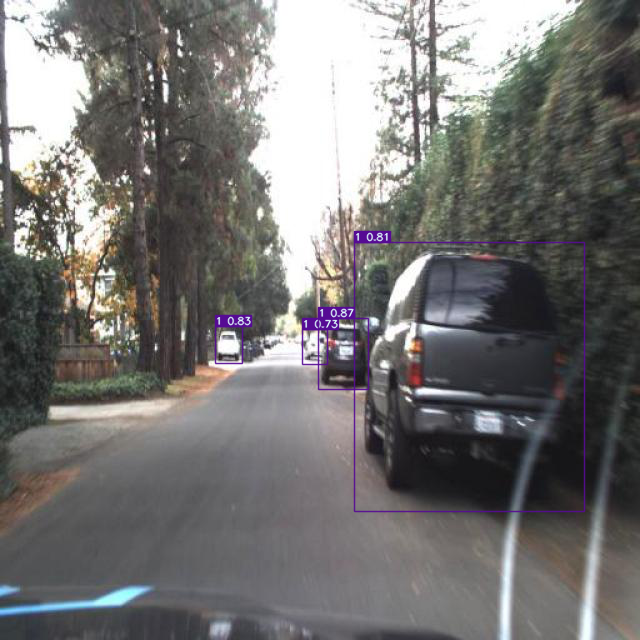

In [7]:
boxes, image, input_shape = detect(compiled_model, 'Intel-OneAPI/test/images/1478901464406581520_jpg.rf.22abdfe90e9afb8d78e278bddecfc654.jpg')
image_with_boxes = draw_boxes(boxes[0], input_shape, image, NAMES, COLORS)
# visualize results
Image.fromarray(image_with_boxes)

In [8]:
from collections import namedtuple
import yaml
from utils.datasets import create_dataloader
from utils.general import check_dataset, box_iou, xywh2xyxy, colorstr

# read dataset config
DATA_CONFIG = 'Intel-OneAPI/data.yaml'
with open(DATA_CONFIG) as f:
    data = yaml.load(f, Loader=yaml.SafeLoader)

# Dataloader
TASK = 'val'  # path to train/val/test images
Option = namedtuple('Options', ['single_cls'])  # imitation of commandline provided options for single class evaluation
opt = Option(False)
dataloader = create_dataloader(
    data[TASK], 640, 1, 32, opt, pad=0.5,
    prefix=colorstr(f'{TASK}: ')
)[0]

val: Scanning 'Intel-OneAPI/valid/labels.cache' images and labels... 1668 found, 322 missing, 192 empty, 0 corrupted: 100%|██████████| 1990/1990 [00:00<?, ?it/s]


In [9]:
import numpy as np
from tqdm.notebook import tqdm
from utils.metrics import ap_per_class


def test(data,
         model: Model,
         dataloader: torch.utils.data.DataLoader,
         conf_thres: float = 0.001,
         iou_thres: float = 0.65,  # for NMS
         single_cls: bool = False,
         v5_metric: bool = False,
         names: List[str] = None,
         num_samples: int = None
        ):
    """
    YOLOv7 accuracy evaluation. Processes validation dataset and compites metrics.

    Parameters:
        model (Model): OpenVINO compiled model.
        dataloader (torch.utils.DataLoader): validation dataset.
        conf_thres (float, *optional*, 0.001): minimal confidence threshold for keeping detections
        iou_thres (float, *optional*, 0.65): IOU threshold for NMS
        single_cls (bool, *optional*, False): class agnostic evaluation
        v5_metric (bool, *optional*, False): use YOLOv5 evaluation approach for metrics calculation
        names (List[str], *optional*, None): names for each class in dataset
        num_samples (int, *optional*, None): number samples for testing
    Returns:
        mp (float): mean precision
        mr (float): mean recall
        map50 (float): mean average precision at 0.5 IOU threshold
        map (float): mean average precision at 0.5:0.95 IOU thresholds
        maps (Dict(int, float): average precision per class
        seen (int): number of evaluated images
        labels (int): number of labels
    """

    model_output = model.output(0)
    check_dataset(data)  # check
    nc = 1 if single_cls else int(data['nc'])  # number of classes
    iouv = torch.linspace(0.5, 0.95, 10)  # iou vector for mAP@0.5:0.95
    niou = iouv.numel()

    if v5_metric:
        print("Testing with YOLOv5 AP metric...")

    seen = 0
    p, r, mp, mr, map50, map = 0., 0., 0., 0., 0., 0.
    stats, ap, ap_class = [], [], []
    for sample_id, (img, targets, _, shapes) in enumerate(tqdm(dataloader)):
        if num_samples is not None and sample_id == num_samples:
            break
        img = prepare_input_tensor(img.numpy())
        targets = targets
        height, width = img.shape[2:]

        with torch.no_grad():
            # Run model
            out = torch.from_numpy(model(img)[model_output])  # inference output
            # Run NMS
            targets[:, 2:] *= torch.Tensor([width, height, width, height])  # to pixels

            out = non_max_suppression(out, conf_thres=conf_thres, iou_thres=iou_thres, labels=None, multi_label=True)
        # Statistics per image
        for si, pred in enumerate(out):
            labels = targets[targets[:, 0] == si, 1:]
            nl = len(labels)
            tcls = labels[:, 0].tolist() if nl else []  # target class
            seen += 1

            if len(pred) == 0:
                if nl:
                    stats.append((torch.zeros(0, niou, dtype=torch.bool), torch.Tensor(), torch.Tensor(), tcls))
                continue
            # Predictions
            predn = pred.clone()
            scale_coords(img[si].shape[1:], predn[:, :4], shapes[si][0], shapes[si][1])  # native-space pred
            # Assign all predictions as incorrect
            correct = torch.zeros(pred.shape[0], niou, dtype=torch.bool, device='cpu')
            if nl:
                detected = []  # target indices
                tcls_tensor = labels[:, 0]
                # target boxes
                tbox = xywh2xyxy(labels[:, 1:5])
                scale_coords(img[si].shape[1:], tbox, shapes[si][0], shapes[si][1])  # native-space labels
                # Per target class
                for cls in torch.unique(tcls_tensor):
                    ti = (cls == tcls_tensor).nonzero(as_tuple=False).view(-1)  # prediction indices
                    pi = (cls == pred[:, 5]).nonzero(as_tuple=False).view(-1)  # target indices
                    # Search for detections
                    if pi.shape[0]:
                        # Prediction to target ious
                        ious, i = box_iou(predn[pi, :4], tbox[ti]).max(1)  # best ious, indices
                        # Append detections
                        detected_set = set()
                        for j in (ious > iouv[0]).nonzero(as_tuple=False):
                            d = ti[i[j]]  # detected target
                            if d.item() not in detected_set:
                                detected_set.add(d.item())
                                detected.append(d)
                                correct[pi[j]] = ious[j] > iouv  # iou_thres is 1xn
                                if len(detected) == nl:  # all targets already located in image
                                    break
            # Append statistics (correct, conf, pcls, tcls)
            stats.append((correct.cpu(), pred[:, 4].cpu(), pred[:, 5].cpu(), tcls))
    # Compute statistics
    stats = [np.concatenate(x, 0) for x in zip(*stats)]  # to numpy
    if len(stats) and stats[0].any():
        p, r, ap, f1, ap_class = ap_per_class(*stats, plot=True, v5_metric=v5_metric, names=names)
        ap50, ap = ap[:, 0], ap.mean(1)  # AP@0.5, AP@0.5:0.95
        mp, mr, map50, map = p.mean(), r.mean(), ap50.mean(), ap.mean()
        nt = np.bincount(stats[3].astype(np.int64), minlength=nc)  # number of targets per class
    else:
        nt = torch.zeros(1)
    maps = np.zeros(nc) + map
    for i, c in enumerate(ap_class):
        maps[c] = ap[i]
    return mp, mr, map50, map, maps, seen, nt.sum()

In [10]:
mp, mr, map50, map, maps, num_images, labels = test(data=data, model=compiled_model, dataloader=dataloader, names=NAMES)
# Print results
s = ('%20s' + '%12s' * 6) % ('Class', 'Images', 'Labels', 'Precision', 'Recall', 'mAP@.5', 'mAP@.5:.95')
print(s)
pf = '%20s' + '%12i' * 2 + '%12.3g' * 4  # print format
print(pf % ('all', num_images, labels, mp, mr, map50, map))

  0%|          | 0/1990 [00:00<?, ?it/s]

               Class      Images      Labels   Precision      Recall      mAP@.5  mAP@.5:.95
                 all        1990       11085       0.728       0.691       0.672       0.361


In [11]:
import nncf  # noqa: F811


def transform_fn(data_item):
    """
    Quantization transform function. Extracts and preprocess input data from dataloader item for quantization.
    Parameters:
       data_item: Tuple with data item produced by DataLoader during iteration
    Returns:
        input_tensor: Input data for quantization
    """
    img = data_item[0].numpy()
    input_tensor = prepare_input_tensor(img)
    return input_tensor


quantization_dataset = nncf.Dataset(dataloader, transform_fn)

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, onnx, openvino


In [13]:
quantized_model = nncf.quantize(model, quantization_dataset, preset=nncf.QuantizationPreset.MIXED)

serialize(model, xml_path="cfg/deploy/yolov7-quant.xml", bin_path="cfg/deploy/yolov7-quant.bin")

RuntimeError: Check 'false' failed at src/inference/src/core.cpp:117:
Check 'false' failed at src/core/src/node.cpp:128:
While validating node 'opset1::VariadicSplit /model.105/Split (/model.105/Sigmoid[0]:f32[1,3,80,80,16], Constant_1970[0]:i32[], Constant_1971[0]:i32[3]) -> (f32[1,3,80,80,2], f32[1,3,80,80,2], f32[1,3,80,80,12])' with friendly_name '/model.105/Split':
Default output not supported

